In [1]:
# === Deal Vintage breakdown by entry_date (fixed date ranges) ===
# Buckets: Early [min_date .. 2007-12-31], Mid [2008-01-01 .. 2019-12-31], Recent [2020-01-01 .. max_date]
from pathlib import Path
import pandas as pd
import numpy as np

# ---- helper ----
def find_upwards(rel_path: Path, max_up: int = 8) -> Path:
    here = Path.cwd()
    for parent in [here, *here.parents][: max_up + 1]:
        p = parent / rel_path
        if p.exists():
            return p.resolve()
    raise FileNotFoundError(f"Couldn't locate '{rel_path.as_posix()}' from {here} by walking up {max_up} levels.")

# ---- paths ----
TARGET_CSV = (find_upwards(Path("ValueCreation")) / "Data" / "working.csv")
OUT_DIR    = (find_upwards(Path("ValueCreation")) / "ValueCreationBreakdown" / "01OverTime")
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_CSV    = OUT_DIR / "deal_vintage.csv"

# ---- load + guards ----
df = pd.read_csv(TARGET_CSV, dtype={"id": str, "deal_id": str})
assert df.groupby("deal_id")["id"].nunique().eq(2).all(), "Expected exactly 2 rows per deal_id."

# ---- identify entry row (earliest reference_date) ----
df["_rank"] = df.groupby("deal_id")["reference_date"].transform(
    lambda s: pd.to_datetime(s, errors="coerce")
).groupby(df["deal_id"]).rank(method="first", ascending=True)

entry = (
    df.loc[df["_rank"] == 1, ["deal_id", "reference_date"]]
      .assign(entry_date=pd.to_datetime(df.loc[df["_rank"] == 1, "reference_date"], errors="coerce").values)
      .drop(columns=["reference_date"])
)

# drop deals with missing entry_date (cannot be bucketed)
entry_clean = entry.dropna(subset=["entry_date"]).copy()

# ---- fixed cutoffs (inclusive ranges) ----
cut_early_end  = pd.Timestamp("2007-12-31")
cut_mid_start  = pd.Timestamp("2008-01-01")
cut_mid_end    = pd.Timestamp("2019-12-31")
cut_recent_start = pd.Timestamp("2020-01-01")

# ---- assign buckets by date (no attempt to equalize counts) ----
d = entry_clean["entry_date"]
conditions = [
    (d <= cut_early_end),
    (d >= cut_mid_start) & (d <= cut_mid_end),
    (d >= cut_recent_start),
]
choices = ["Early", "Mid", "Recent"]
entry_clean["vintage_bucket"] = np.select(conditions, choices, default=pd.NA)

# ---- attach vintage bucket to all rows of each deal ----
bucket_map  = entry_clean.set_index("deal_id")["vintage_bucket"].to_dict()
date_map    = entry_clean.set_index("deal_id")["entry_date"].to_dict()

out = df.copy()
out["entry_date"]     = out["deal_id"].map(date_map)
out["vintage_bucket"] = out["deal_id"].map(bucket_map)

# persist
out.to_csv(OUT_CSV, index=False)

# ---- print bucket date ranges (actual min/max observed per bucket) ----
def bucket_range(frame):
    if frame.empty:
        return {"count": 0, "start": "—", "end": "—"}
    d = pd.to_datetime(frame["entry_date"], errors="coerce")
    return {
        "count": int(frame["deal_id"].nunique()),
        "start": pd.to_datetime(np.nanmin(d)).date().isoformat(),
        "end":   pd.to_datetime(np.nanmax(d)).date().isoformat(),
    }

stats = {}
for b in ["Early", "Mid", "Recent"]:  # chronological
    sub = entry_clean.loc[entry_clean["vintage_bucket"] == b]
    stats[b] = bucket_range(sub)

print(f"Wrote: {OUT_CSV}")
print("Deal counts per vintage bucket:", {k: v["count"] for k, v in stats.items()})
label_map = {"Early": "Early vintage", "Mid": "Mid vintage", "Recent": "Recent vintage"}
for b in ["Early", "Mid", "Recent"]:
    s = stats[b]
    print(f"{label_map[b]} — n={s['count']}, range=[{s['start']} … {s['end']}]")
print("Nominal bucket cutoffs: Early ≤ 2007-12-31; Mid 2008-01-01–2019-12-31; Recent ≥ 2020-01-01")


Wrote: /Users/michael/Library/Mobile Documents/com~apple~CloudDocs/Studium TUM/Master Management and Technology/06 Master Thesis/00 Thesis/05Code/ValueCreation/ValueCreationBreakdown/01OverTime/deal_vintage.csv
Deal counts per vintage bucket: {'Early': 71, 'Mid': 176, 'Recent': 98}
Early vintage — n=71, range=[1995-07-11 … 2007-10-31]
Mid vintage — n=176, range=[2008-02-01 … 2019-12-31]
Recent vintage — n=98, range=[2020-01-31 … 2024-12-31]
Nominal bucket cutoffs: Early ≤ 2007-12-31; Mid 2008-01-01–2019-12-31; Recent ≥ 2020-01-01


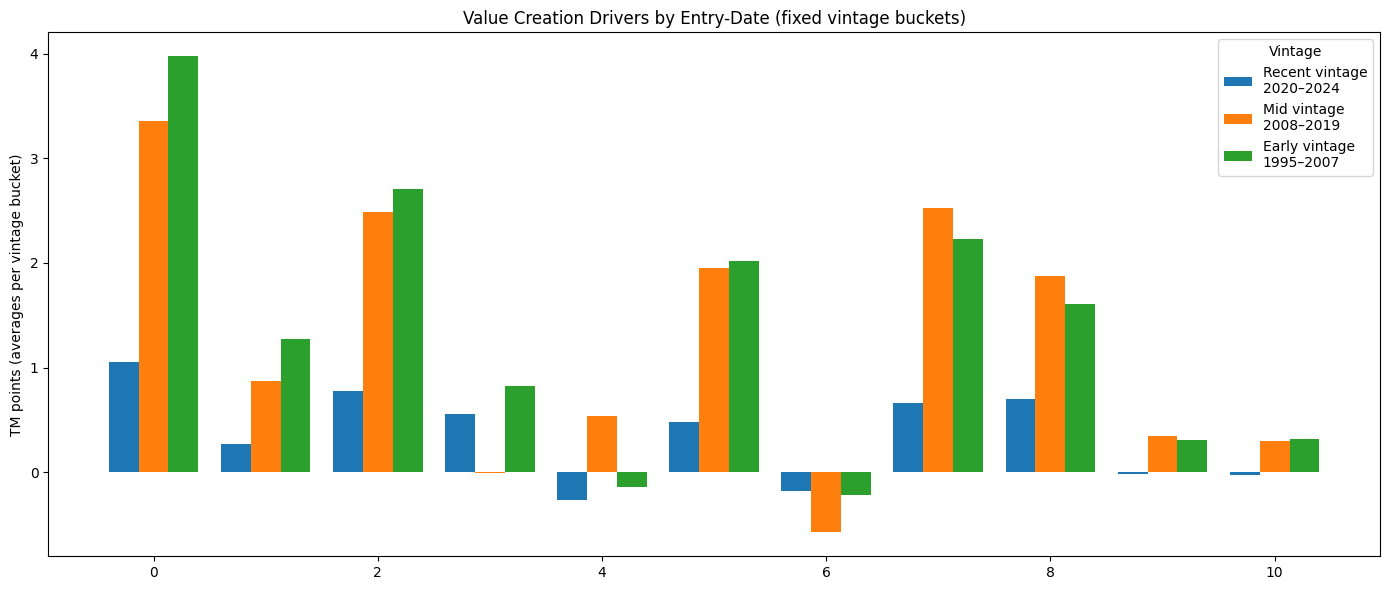

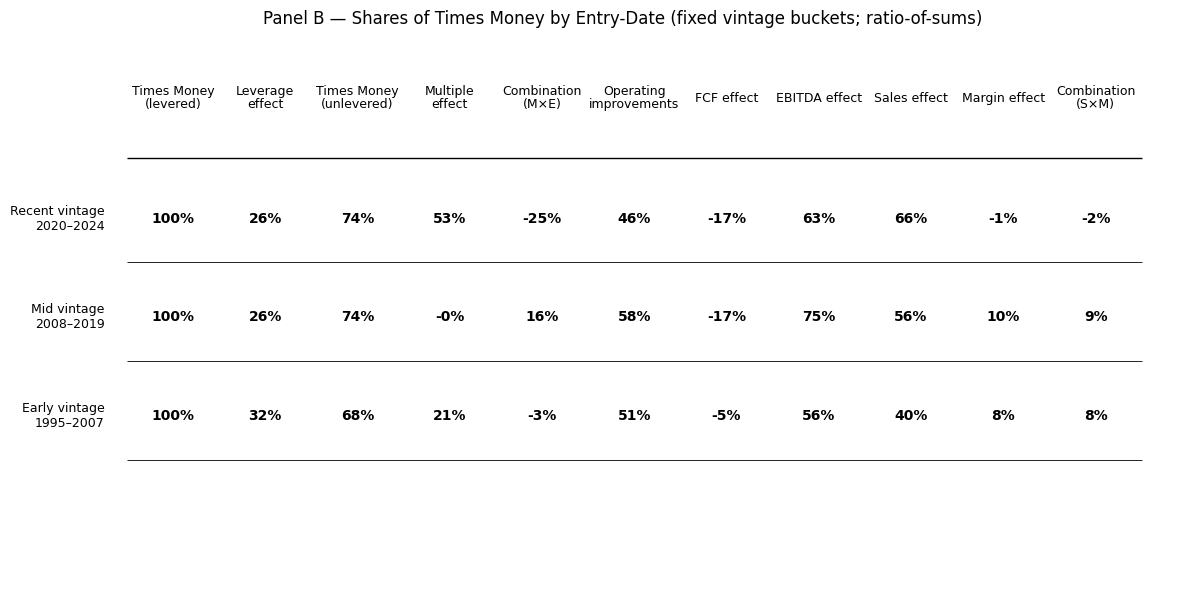

In [2]:
# === Vintage Bridge — Clustered Bars by entry-date terciles (Early/Mid/Recent) ===
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textwrap

# ---------- paths ----------
def find_upwards(rel_path: Path, max_up: int = 8) -> Path:
    here = Path.cwd()
    for parent in [here, *here.parents][: max_up + 1]:
        p = parent / rel_path
        if p.exists():
            return p.resolve()
    raise FileNotFoundError(f"Couldn't locate '{rel_path.as_posix()}' from {here} by walking up {max_up} levels.")

BASE       = find_upwards(Path("ValueCreation"))
WORK_CSV   = (BASE / "Data" / "working.csv")
VINT_CSV   = (BASE / "ValueCreationBreakdown" / "01OverTime" / "deal_vintage.csv")

# ---------- load ----------
work   = pd.read_csv(WORK_CSV, dtype={"deal_id": str})
vint   = pd.read_csv(VINT_CSV, dtype={"deal_id": str})

# ---------- deal-view (1 row per deal) + join vintage buckets ----------
NUMERIC_COLS = [
    "times_money","leverage_effect","tm_unlevered",
    "tmu_contrib_multiple_effect",
    "tmu_contrib_multiple_ebitda_combination_effect",
    "tmu_contrib_fcf_effect",
    "tmu_contrib_ebitda_effect",
    "tmu_contrib_sales_effect",
    "tmu_contrib_margin_effect",
    "tmu_contrib_sales_margin_combination_effect",
]
need = ["deal_id","vintage_bucket"] + NUMERIC_COLS

deal_metrics = work.groupby("deal_id", as_index=False)[NUMERIC_COLS].first()
deal_buckets = vint.groupby("deal_id", as_index=False)[["vintage_bucket"]].first()
deal = deal_metrics.merge(deal_buckets, on="deal_id", how="left")[need]

# keep only labeled terciles
deal = deal[deal["vintage_bucket"].isin(["Recent","Mid","Early"])].copy()

# ---------- per-bucket means (TM points) ----------
grp = deal.groupby("vintage_bucket")

means = pd.DataFrame({
    "Times Money (levered)"  : grp["times_money"].mean(),
    "Leverage effect"        : grp["leverage_effect"].mean(),
    "Times Money (unlevered)": grp["tm_unlevered"].mean(),
    "Multiple effect"        : grp["tmu_contrib_multiple_effect"].mean(),
    "Combination (M×E)"      : grp["tmu_contrib_multiple_ebitda_combination_effect"].mean(),
    "Operating improvements" : grp["tmu_contrib_fcf_effect"].mean() + grp["tmu_contrib_ebitda_effect"].mean(),
    "FCF effect"             : grp["tmu_contrib_fcf_effect"].mean(),
    "EBITDA effect"          : grp["tmu_contrib_ebitda_effect"].mean(),
    "Sales effect"           : grp["tmu_contrib_sales_effect"].mean(),
    "Margin effect"          : grp["tmu_contrib_margin_effect"].mean(),
    "Combination (S×M)"      : grp["tmu_contrib_sales_margin_combination_effect"].mean(),
}).T  # rows = components, cols = buckets

# enforce desired bucket order (columns) and component order (rows)
bucket_order = ["Recent","Mid","Early"]  # mirrors "High, Mid, Low" display idea
means = means.reindex(columns=bucket_order)

component_order = [
    "Times Money (levered)",
    "Leverage effect",
    "Times Money (unlevered)",
    "Multiple effect",
    "Combination (M×E)",
    "Operating improvements",
    "FCF effect",
    "EBITDA effect",
    "Sales effect",
    "Margin effect",
    "Combination (S×M)",
]
means = means.reindex(component_order)

# --- dynamic labels built from observed entry_date ranges (YYYY only) ---
bucket_order = ["Recent","Mid","Early"]  # already used below

# ensure entry_date is datetime
v_dates = (
    vint[["vintage_bucket", "entry_date"]]
    .dropna(subset=["vintage_bucket", "entry_date"])
    .assign(entry_date=lambda x: pd.to_datetime(x["entry_date"], errors="coerce"))
    .dropna(subset=["entry_date"])
)

obs = v_dates.groupby("vintage_bucket")["entry_date"].agg(["min", "max"])

def label_for(bucket: str, title: str) -> str:
    if bucket in obs.index:
        sy = int(obs.loc[bucket, "min"].year)
        ey = int(obs.loc[bucket, "max"].year)
        return f"{title} vintage\n{sy}–{ey}"
    # fallback if bucket has no rows
    return f"{title} vintage"

DISPLAY_LABELS = {
    "Recent": label_for("Recent", "Recent"),
    "Mid":    label_for("Mid",    "Mid"),
    "Early":  label_for("Early",  "Early"),
}


# ---------- plot: clustered bars (one component group, 3 bars = fixed vintage buckets) ----------
fig, ax = plt.subplots(figsize=(14, 6))

n_comp   = len(means.index)
n_bucket = len(means.columns)
x        = np.arange(n_comp)
width    = 0.8 / n_bucket

for i, b in enumerate(means.columns):  # b ∈ {"Recent","Mid","Early"}
    ax.bar(x + (i - (n_bucket-1)/2) * width, means[b].to_numpy(),
           width=width, label=DISPLAY_LABELS[b])

ax.set_ylabel("TM points (averages per vintage bucket)")
ax.set_title("Value Creation Drivers by Entry-Date (fixed vintage buckets)")
ax.legend(title="Vintage")

fig.tight_layout()
plt.show()

# ---------- Panel B — table-style visualization (shares of Times Money) ----------
cols_needed = [
    "times_money","leverage_effect",
    "tmu_contrib_multiple_effect",
    "tmu_contrib_multiple_ebitda_combination_effect",
    "tmu_contrib_fcf_effect",
    "tmu_contrib_ebitda_effect",
    "tmu_contrib_sales_effect",
    "tmu_contrib_margin_effect",
    "tmu_contrib_sales_margin_combination_effect",
]
grp = deal.groupby("vintage_bucket")
S = grp[cols_needed].sum().reindex(bucket_order)
den = S["times_money"].astype(float)
assert np.all(np.abs(den.values) > 1e-12), "Zero total Times Money in at least one tercile."

def pct(col):
    return (S[col] / den) * 100.0

panelB = pd.DataFrame(index=bucket_order, columns=component_order, dtype=float)
panelB.loc[:, "Times Money (levered)"]   = 100.0
panelB.loc[:, "Leverage effect"]         = pct("leverage_effect")
panelB.loc[:, "Multiple effect"]         = pct("tmu_contrib_multiple_effect")
panelB.loc[:, "Combination (M×E)"]       = pct("tmu_contrib_multiple_ebitda_combination_effect")
panelB.loc[:, "FCF effect"]              = pct("tmu_contrib_fcf_effect")
panelB.loc[:, "EBITDA effect"]           = pct("tmu_contrib_ebitda_effect")
panelB.loc[:, "Sales effect"]            = pct("tmu_contrib_sales_effect")
panelB.loc[:, "Margin effect"]           = pct("tmu_contrib_margin_effect")
panelB.loc[:, "Combination (S×M)"]       = pct("tmu_contrib_sales_margin_combination_effect")
panelB.loc[:, "Operating improvements"]  = panelB["FCF effect"] + panelB["EBITDA effect"]
panelB.loc[:, "Times Money (unlevered)"] = (
    panelB["Multiple effect"] + panelB["Combination (M×E)"] + panelB["Operating improvements"]
)

# --- table-like figure with headers and three rows (Recent/Mid/Early) ---
headers = component_order
rows    = bucket_order  # ["Recent","Mid","Early"]

n_cols = len(headers)
n_rows = len(rows)
fig_h  = 3.6 + (n_rows-1) * 1.2
fig, ax = plt.subplots(figsize=(12, fig_h))
ax.set_axis_off()

left_margin, right_margin = 0.05, 0.97
xs = left_margin + (np.arange(n_cols) + 0.5) * (right_margin - left_margin) / n_cols

y_header = 0.88
row_start = 0.66
row_gap   = 0.18
ys = [row_start - i*row_gap for i in range(n_rows)]

wrap_w = 14
for x_pos, hdr in zip(xs, headers):
    ax.text(x_pos, y_header, textwrap.fill(hdr, width=wrap_w),
            ha="center", va="center", fontsize=9, linespacing=1.05, transform=ax.transAxes)

row_label_x = left_margin - 0.02

row_label_x = left_margin - 0.02
for y_pos, r in zip(ys, rows):  # rows == bucket_order
    ax.text(row_label_x, y_pos, DISPLAY_LABELS[r],
            ha="right", va="center", fontsize=9, transform=ax.transAxes)

for y_pos, r in zip(ys, rows):
    for x_pos, hdr in zip(xs, headers):
        val = panelB.loc[r, hdr]
        ax.text(x_pos, y_pos, f"{val:.0f}%", ha="center", va="center",
                fontsize=10, fontweight="bold", transform=ax.transAxes)

sep_top = (y_header + ys[0]) / 2
ax.hlines([sep_top], xmin=left_margin, xmax=right_margin,
          colors="black", linewidth=1.0, transform=ax.transAxes)
for y_pos in ys:
    ax.hlines([y_pos - row_gap/2 + 0.01], xmin=left_margin, xmax=right_margin,
              colors="black", linewidth=0.6, transform=ax.transAxes)

ax.set_title("Panel B — Shares of Times Money by Entry-Date (fixed vintage buckets; ratio-of-sums)", pad=6)
fig.tight_layout()
plt.show()


In [3]:
"""
# === Deal Vintage breakdown by entry_date (terciles) ===
# Buckets: Early, Mid, Recent
from pathlib import Path
import pandas as pd
import numpy as np

# ---- helper ----
def find_upwards(rel_path: Path, max_up: int = 8) -> Path:
    here = Path.cwd()
    for parent in [here, *here.parents][: max_up + 1]:
        p = parent / rel_path
        if p.exists():
            return p.resolve()
    raise FileNotFoundError(f"Couldn't locate '{rel_path.as_posix()}' from {here} by walking up {max_up} levels.")

# ---- paths ----
TARGET_CSV = (find_upwards(Path("ValueCreation")) / "Data" / "working.csv")
OUT_DIR    = (find_upwards(Path("ValueCreation")) / "ValueCreationBreakdown" / "01OverTime")
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_CSV    = OUT_DIR / "deal_vintage.csv"

# ---- load + guards ----
df = pd.read_csv(TARGET_CSV, dtype={"id": str, "deal_id": str})
assert df.groupby("deal_id")["id"].nunique().eq(2).all(), "Expected exactly 2 rows per deal_id."

# ---- identify entry row (earliest reference_date) ----
df["_rank"] = df.groupby("deal_id")["reference_date"].transform(
    lambda s: pd.to_datetime(s, errors="coerce")
).groupby(df["deal_id"]).rank(method="first", ascending=True)

entry = (
    df.loc[df["_rank"] == 1, ["deal_id", "reference_date"]]
      .assign(entry_date=pd.to_datetime(df.loc[df["_rank"] == 1, "reference_date"], errors="coerce").values)
      .drop(columns=["reference_date"])
)

# drop deals with missing entry_date (cannot be bucketed)
entry_clean = entry.dropna(subset=["entry_date"]).copy()

# ---- deterministic ordering to handle ties ----
entry_clean = entry_clean.sort_values(["entry_date", "deal_id"], ascending=[True, True]).reset_index(drop=True)

# ---- assign terciles with near-equal counts (rank-based) ----
n = len(entry_clean)
if n == 0:
    raise ValueError("No deals with valid entry_date to bucket.")

base, rem = divmod(n, 3)
sizes = [base, base, base]
for i in range(rem):              # distribute remainder to the most Recent, then Mid
    sizes[2 - i] += 1

labels = np.array(
    ["Early"]  * sizes[0] +
    ["Mid"]    * sizes[1] +
    ["Recent"] * sizes[2]
)
entry_clean["vintage_bucket"] = labels

# ---- attach vintage bucket to all rows of each deal ----
bucket_map  = entry_clean.set_index("deal_id")["vintage_bucket"].to_dict()
date_map    = entry_clean.set_index("deal_id")["entry_date"].to_dict()

out = df.copy()
out["entry_date"]     = out["deal_id"].map(date_map)
out["vintage_bucket"] = out["deal_id"].map(bucket_map)

# persist
out.to_csv(OUT_CSV, index=False)

# ---- print bucket date ranges ----
def bucket_range(frame):
    d = pd.to_datetime(frame["entry_date"], errors="coerce")
    return {
        "count": int(frame["deal_id"].nunique()),
        "start": pd.to_datetime(np.nanmin(d)).date().isoformat(),
        "end":   pd.to_datetime(np.nanmax(d)).date().isoformat(),
    }

stats = {}
for b in ["Early", "Mid", "Recent"]:  # ascending by date
    sub = entry_clean.loc[entry_clean["vintage_bucket"] == b]
    stats[b] = bucket_range(sub)

print(f"Wrote: {OUT_CSV}")
print("Deal counts per vintage bucket (near-equal):", {k: v["count"] for k, v in stats.items()})
label_map = {"Early": "Early vintage", "Mid": "Mid vintage", "Recent": "Recent vintage"}
for b in ["Early", "Mid", "Recent"]:
    s = stats[b]
    print(f"{label_map[b]} — n={s['count']}, range=[{s['start']} … {s['end']}]")
"""

'\n# === Deal Vintage breakdown by entry_date (terciles) ===\n# Buckets: Early, Mid, Recent\nfrom pathlib import Path\nimport pandas as pd\nimport numpy as np\n\n# ---- helper ----\ndef find_upwards(rel_path: Path, max_up: int = 8) -> Path:\n    here = Path.cwd()\n    for parent in [here, *here.parents][: max_up + 1]:\n        p = parent / rel_path\n        if p.exists():\n            return p.resolve()\n    raise FileNotFoundError(f"Couldn\'t locate \'{rel_path.as_posix()}\' from {here} by walking up {max_up} levels.")\n\n# ---- paths ----\nTARGET_CSV = (find_upwards(Path("ValueCreation")) / "Data" / "working.csv")\nOUT_DIR    = (find_upwards(Path("ValueCreation")) / "ValueCreationBreakdown" / "01OverTime")\nOUT_DIR.mkdir(parents=True, exist_ok=True)\nOUT_CSV    = OUT_DIR / "deal_vintage.csv"\n\n# ---- load + guards ----\ndf = pd.read_csv(TARGET_CSV, dtype={"id": str, "deal_id": str})\nassert df.groupby("deal_id")["id"].nunique().eq(2).all(), "Expected exactly 2 rows per deal_id."\n\n